Using device: cuda


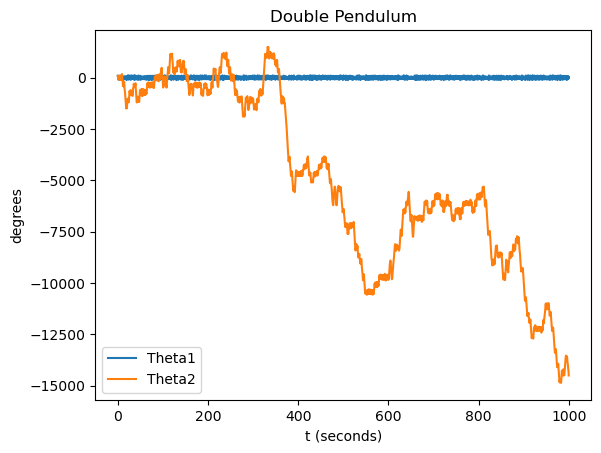

Epoch 1, Train Loss: 0.0768, Validation Loss: 0.0001
Epoch 2, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 3, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 4, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 5, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 6, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 7, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 8, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 9, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 10, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 11, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 12, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 13, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 14, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 15, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 16, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 17, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 18, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 19, Train Loss: 0.0000, Validat

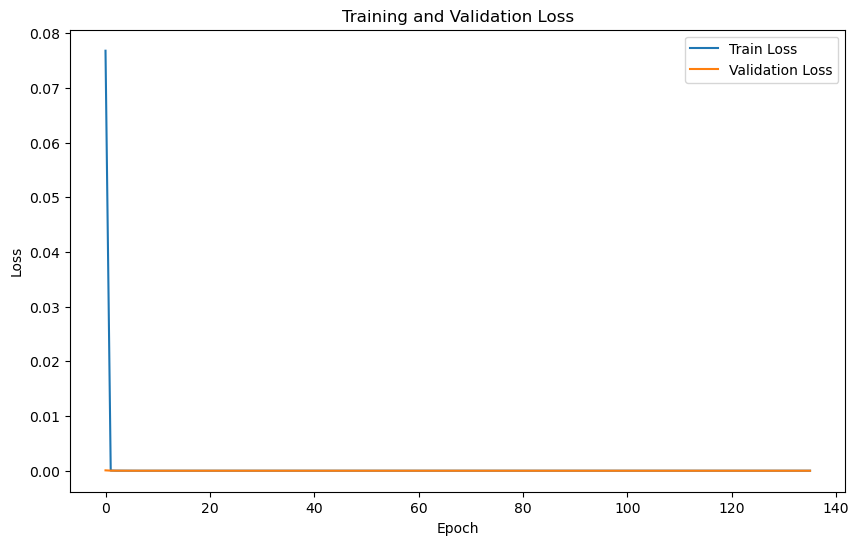

Test RMSE: 5.5906919442350045e-05
R^2 Score: 0.9999999477855137


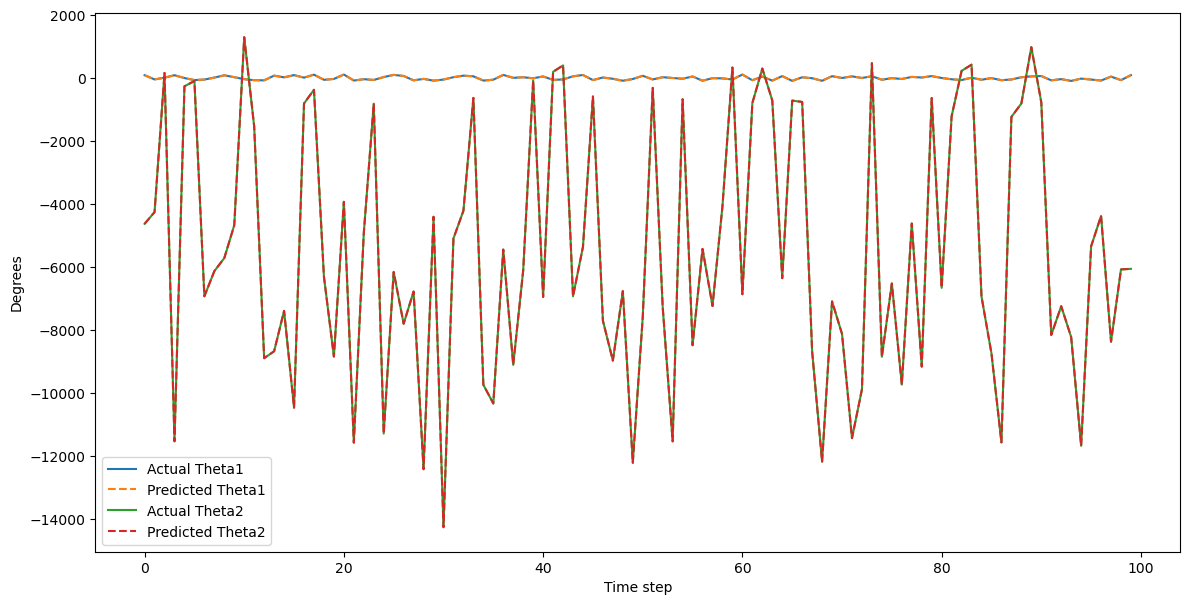

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from numpy import array
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

g = 9.81
L1 = 1
L2 = 1
m1 = 1.0
m2 = 1.0

def f(r, t, L1, L2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]
    ftheta1 = omega1
    fomega1 = (-g * (2 * m1 + m2) * sin(theta1) - m2 * g * sin(theta1 - 2 * theta2) - 2 * sin(theta1 - theta2) * m2 *
               (omega2**2 * L2 + omega1**2 * L1 * cos(theta1 - theta2))) / (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))
    ftheta2 = omega2
    fomega2 = (2 * sin(theta1 - theta2) * (omega1**2 * L1 * (m1 + m2) + g * (m1 + m2) * cos(theta1) + omega2**2 * L2 * m2 *
                                           cos(theta1 - theta2))) / (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))
    return array([ftheta1, fomega1, ftheta2, fomega2], float)

a = 0.0
b = 1000
N = 1000000
h = (b - a) / N

tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)
theta2_points = np.zeros_like(tpoints)
q = np.array([pi / 2, 0, pi / 2, 0], float)

for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / pi
    theta2_points[i] = q[2] * 180 / pi
    k1 = h * f(q, t, L1, L2)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h, L1, L2)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h, L1, L2)
    k4 = h * f(q + k3, t + h, L1, L2)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

plt.plot(tpoints, theta1_points, label='Theta1')
plt.plot(tpoints, theta2_points, label='Theta2')
plt.title("Double Pendulum")
plt.xlabel("t (seconds)")
plt.ylabel("degrees")
plt.legend()
plt.show()

# Combine Data
data = np.stack((theta1_points, theta2_points), axis=1)
np.save('pendulum_data.npy', data)

# Load Data
data = np.load('pendulum_data.npy')

# Normalize Data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Create Sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create Training and Testing Sets
SEQ_LENGTH = 50
X, Y = create_sequences(data, SEQ_LENGTH)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(Y_train, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(Y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# GRU Model Definition
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        output = self.linear(gru_out[:, -1, :])
        return output

input_size = 2
hidden_layer_size = 50
output_size = 2
model = GRUModel(input_size, hidden_layer_size, output_size).to(device)

# Initializing weights and biases
for name, param in model.named_parameters():
    if 'weight' in name:
        nn.init.xavier_normal_(param)  # Xavier initialization
    elif 'bias' in name:
        nn.init.uniform_(param, -0.1, 0.1)

# Initializing loss and optimizer functions
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
NUM_EPOCHS = 150
PATIENCE = 10

# Training model with loss tracking and early stopping
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs, patience):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = loss_function(y_pred, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, targets in val_loader:
                y_pred = model(sequences)
                loss = loss_function(y_pred, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

train_model(model, train_loader, test_loader, NUM_EPOCHS, PATIENCE)

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluating the model
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            y_pred = model(sequences)
            loss = torch.sqrt(loss_function(y_pred, targets))
            test_loss += loss.item()
            # Append predictions and targets without reshaping
            all_predictions.append(y_pred.detach().cpu().numpy())
            all_targets.append(targets.detach().cpu().numpy())
    avg_test_loss = test_loss / len(test_loader)
    # Concatenate along the batch dimension (axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    # Reshape to match for r2_score: (num_samples, num_outputs)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    print(f'Test RMSE: {rmse}')
    r2 = r2_score(all_targets, all_predictions)
    print(f'R^2 Score: {r2}')

evaluate_model(model, test_loader)

# Predict and plot results
model.eval()
with torch.no_grad():
    for sequences, targets in test_loader:
        y_pred = model(sequences)
        break

y_pred_original = scaler.inverse_transform(y_pred.cpu().numpy())
targets_original = scaler.inverse_transform(targets.cpu().numpy())

time_steps_to_plot = 100  # Number of time steps to plot

plt.figure(figsize=(14, 7))
plt.plot(targets_original[:time_steps_to_plot, 0], label='Actual Theta1')
plt.plot(y_pred_original[:time_steps_to_plot, 0], label='Predicted Theta1', linestyle='dashed')
plt.plot(targets_original[:time_steps_to_plot, 1], label='Actual Theta2')
plt.plot(y_pred_original[:time_steps_to_plot, 1], label='Predicted Theta2', linestyle='dashed')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()
